<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
### <center> Author: I_Kalininskii, Kiavip at ODS Slack 
    
## <center> Individual project
### <center> "Sberbank Russian Housing Market"

[Kaggle competition overview](#Kaggle-competition-overview)<br>
[Main assumptions](#Main_assumptions)<br>
[Part 1. Dataset and features description](#Part-1.-Dataset-and-features-description )<br>
[Part 2. Exploratory data analysis](#Part-2.-Exploratory-data-analysis)<br>
[Part 3. Visual analysis of the features](#Part-3.-Visual-analysis-of-the-features)<br>
[Part 4. Patterns, insights, pecularities of data](#Part-4.-Patterns,-insights,-pecularities-of-data)<br>
[Part 5. Data preprocessing](#Part-5.-Data-preprocessing)<br>
[Part 6. Feature engineering and description](#Part-6.-Feature-engineering-and-description)<br>
[Part 7. Cross-validation, hyperparameter tuning](#Part-7.-Cross-validation,-hyperparameter-tuning)<br>
[Part 8. Validation and learning curves](#Part-8.-Validation-and-learning-curves)<br>
[Part 9. Prediction for hold-out and test samples ](#Part-9.-Prediction-for-hold-out-and-test-samples )<br>
[Part 10. Model evaluation with metrics description](#Part-10.-Model-evaluation-with-metrics-description)<br>
[Part 11. Conclusions](#Part-11.-Conclusions)<br>

## Kaggle competition overview

Housing costs demand a significant investment from both consumers and developers. And when it comes to planning a budget—whether personal or corporate—the last thing anyone needs is uncertainty about one of their biggets expenses. Sberbank, Russia’s oldest and largest bank, helps their customers by making predictions about realty prices so renters, developers, and lenders are more confident when they sign a lease or purchase a building.

Although the housing market is relatively stable in Russia, the country’s volatile economy makes forecasting prices as a function of apartment characteristics a unique challenge. Complex interactions between housing features such as number of bedrooms and location are enough to make pricing predictions complicated. Adding an unstable economy to the mix means Sberbank and their customers need more than simple regression models in their arsenal.

In this competition, Sberbank is challenging Kagglers to develop algorithms which use a broad spectrum of features to predict realty prices. Competitors will rely on a rich dataset that includes housing data and macroeconomic patterns. An accurate forecasting model will allow Sberbank to provide more certainty to their customers in an uncertain economy.

## Project data

Datasets and their description are on Kaggle and it's much safer than any other location I can offer.<br>
__[Download all from Kaggle](https://www.kaggle.com/c/6392/download-all)__<br>
__[Kaggle competition Data page](https://www.kaggle.com/c/sberbank-russian-housing-market/data)__

## Main assumptions

I'm interested in Sberbank strategy and in Moscow realty prices, so I'll try to learn as much as I can out of this project.

I'll try to examine most obvious features in datasets, then, i'll compare train and test sets to see, are they comparable. Also' I'll try to enhance the model by using macroeconomical features as well as cleaning data and feature engineering. 

As a model, I'll use LightGBM. It's new to me and I want to learn, how to build a robust predictions using gradient boosting. I want to use ensemble, but I think, ensembling will take more time, and I'd better stick to one decision.

As a metric, I'll choose RMSLE, as it is the one set for this competition.

In [ ]:
import numpy as np
import pandas as pd
import pylab
import calendar
from datetime import datetime
from scipy import stats
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

import lightgbm as lgb
from sklearn.metrics import mean_squared_error

### Part 1. Dataset and features description

Here I'm going to read data from csv files. There are three files:
1. train.csv: data and target variable for model training
2. test.csv: data to make prediction of target variable by trained model
3. macro.csv: additional data both for training and making prediction

Features described in file data_dictionary.txt, and description is significantly long, so I'll not copy that content here. Later I'll describe groups of columns.

In [ ]:
train_df = pd.read_csv("train.csv", parse_dates=['timestamp'])
test_df = pd.read_csv("test.csv", parse_dates=['timestamp'])
macro_df = pd.read_csv("macro.csv", parse_dates=['timestamp'])

In [ ]:
print (train_df.shape, test_df.shape, macro_df.shape)

I experienced some troubles with *timestamp* column at **macro_df**. It seems, no one else had such behavior, but I need to cast it to *datetime64[ns]* or compatible.

In [ ]:
macro_df['timestamp']=macro_df['timestamp'].apply(lambda s: pd.to_datetime(s+' 00:00:00'))
macro_df['timestamp'].dtype

In [ ]:
train_df.head().T

**train_df** is dataframe containing 292 features. Data exploratory analysis will come later. Now only brief explanations of these features, as they described in annotation to competition:


price_doc: sale price (this is the target variable)

In [ ]:
test_df.head().T

Same columns, as in **train_df**, but without a target.

In [ ]:
macro_df.head().T

**macro_df** contains 99 features related to Russia's macroeconomy and financial sector and timestamp to join to the **train_df** and **test_df**. These stats are collected daily, so 2485 days are approximately 7 years.

### Part 2. Exploratory data analysis

I will explore target variable **price_doc**. Price can be quite imbalanced, I'll apply logarithm to see, if it can looks like normal distibution.

In [ ]:
train_df['price_doc'].describe()

Target description is nice. I see, 75 quartile is 8.3 million, so reasonable. But there is some huge prices, of course, realty market may contain such offers.

I'll find skewness and kurtosis

In [ ]:
print("Skewness: %f" % train_df['price_doc'].skew())
print("Kurtosis: %f" % train_df['price_doc'].kurt())

In [ ]:
train_df['price_doc_log'] = np.log1p(train_df['price_doc'])

In [ ]:
print("Skewness: %f" % train_df['price_doc_log'].skew())
print("Kurtosis: %f" % train_df['price_doc_log'].kurt())

Skewness closer to zero and kurtosis less than original of *price_doc*. I think, logarithmic target will be better to predict. 

In [ ]:
fig,axes = plt.subplots(ncols=2)
fig.set_size_inches(20,10)
sn.kdeplot(data=train_df["price_doc"], color="r", shade=True,ax=axes[0])
sn.kdeplot(data=train_df["price_doc_log"], color="r", shade=True,ax=axes[1])

In [ ]:
fig,axes = plt.subplots(ncols=2)
fig.set_size_inches(20,10)
sn.kdeplot(data=train_df[(train_df["price_doc"]>1e6) & (train_df["price_doc"]!=2e6) & (train_df["price_doc"]!=3e6)]["price_doc"], color="r", shade=True,ax=axes[0])
sn.kdeplot(data=train_df[(train_df["price_doc"]>1e6) & (train_df["price_doc"]!=2e6) & (train_df["price_doc"]!=3e6)]["price_doc_log"], color="r", shade=True,ax=axes[1])

Without some values, distributions seems more smooth. I'll prepare method of cleaning this values and call it at next step.

In [ ]:
def remove_abnormal_prices(df):
    df.drop(df[(df["price_doc"]<=1e6) | (df["price_doc"]==2e6) | (df["price_doc"]==3e6)].index,
              inplace=True)

In [ ]:
fig,axes = plt.subplots(ncols=2)
fig.set_size_inches(20, 10)
stats.probplot(train_df["price_doc_log"], dist='norm', fit=True, plot=axes[0])
stats.probplot(train_df[(train_df["price_doc"]>1e6) & (train_df["price_doc"]!=2e6) & (train_df["price_doc"]!=3e6)]["price_doc_log"], dist='norm', fit=True, plot=axes[1])

It seems, logarithm target has normal distibution with some deviations. Model will be trained on *log* Target to get better predictions and satisfy metric condidions. 

I'll look on *product_type* relation to *price_doc_log*.

In [ ]:
ax = sn.FacetGrid(train_df, col="product_type", size=6)
ax.map(sn.kdeplot, "price_doc_log", color="r", shade=True)
ax.add_legend()
ax.set(ylabel='density')

Investment realty price tends to have round value, 1e6 - one million, 2e6 - two millions, etc.

### Part 3. Visual analysis of the features

I'll explore datatypes of features in **train_df**.

In [ ]:
dataTypeDf = pd.DataFrame(train_df.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"})
fig,ax = plt.subplots()
fig.set_size_inches(20,5)
sn.barplot(data=dataTypeDf,x="variableType",y="count",ax=ax)
ax.set(xlabel='Variable Type', ylabel='Count',title="Variables Count Across Datatype")

*int84* and *float64* values are good for regression. Features marked as *object* are categorical variables. *datetime64[ns]* is **timestamp** column.

I'll look for missing values in **train_df**

In [ ]:
train_na = (train_df.isnull().sum() / len(train_df)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)

In [ ]:
f, ax = plt.subplots(figsize=(12, 8))
plt.xticks(rotation='90')
sn.barplot(x=train_na.index, y=train_na)
ax.set(title='Percent missing data by feature', ylabel='% missing')

Of 292 columns, 51 have missing values. The percentage of values missing ranges from 0.1% in metro_min_walk to 47.4% in hospital_beds_raion. I'll think, how to deal with it. Remain it intact is an option, though.

I need to get some new features derived from timestamp to continue.

In [ ]:
train_df['year'] = train_df['timestamp'].apply(lambda ts: ts.year)
train_df['month'] = train_df['timestamp'].apply(lambda ts:ts. month)

test_df['year'] = test_df['timestamp'].apply(lambda ts: ts.year)
test_df['month'] = test_df['timestamp'].apply(lambda ts: ts.month)

In [ ]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(20,5)
sn.boxplot(data=train_df,y="price_doc",orient="v",ax=ax1)
sn.boxplot(data=train_df,x="price_doc",y="year",orient="h",ax=ax2)

fig1,ax3 = plt.subplots()
fig1.set_size_inches(20,5)
sn.boxplot(data=train_df,x="month",y="price_doc",orient="v",ax=ax3)
ax1.set(ylabel='Price Doc', title="Box Plot On Price Doc")
ax2.set(xlabel='Price Doc', ylabel='Year',title="Box Plot On Price Doc Across Year")
ax3.set(xlabel='Month', ylabel='Count',title="Box Plot On Price Doc Across Month")

In [ ]:
stateDf = pd.DataFrame(train_df[~train_df['state'].isnull()]['state'].value_counts()).reset_index().rename(columns={"index":"state","state":"count"})
stateDf
fig,ax = plt.subplots()
fig.set_size_inches(20,5)
sn.barplot(data=stateDf,x="state",y="count",ax=ax)
ax.set(xlabel='state', ylabel='Count',title="Variables Count Across Datatype")

State should be discrete valued between 1 and 4. There is a 33 in it that is cleary a data entry error
Lets just replace it with value 3.

In [ ]:
def correct_state_33(df):
    df.loc[df['state'] == 33, 'state'] = 3

I'll explore *build_year* feature

In [ ]:
f, ax = plt.subplots(figsize=(12, 8))
plt.xticks(rotation='90')
ind = train_df[(train_df['build_year'] <= 1691) | (train_df['build_year'] >= 2018)].index
by_df = train_df.drop(ind).sort_values(by=['build_year'])
sn.countplot(x=by_df['build_year'])
ax.set(title='Distribution of build year')

The distribution appears bimodal with a peak somewhere in the early 1970s and somewhere in the past few years.

In [ ]:
buildYearDf = pd.DataFrame(train_df[(train_df['build_year']<1147)|(train_df['build_year']>2030)]['build_year'].value_counts()).reset_index().rename(columns={"index":"build_year","build_year":"count"})
buildYearDf
fig,ax = plt.subplots()
fig.set_size_inches(20,5)
sn.barplot(data=buildYearDf,x="build_year",y="count",ax=ax)
ax.set(xlabel='Build Year', ylabel='Count',title="Count Across build_year")

Build_year has some erroneous values. Since its unclear what they should be, let's replace 20052009 with 2007, 4965 with 1965, 20 with 1920, 71 with 1971. Values 0, 1, 3 remain intact.

In [ ]:
def clean_build_year(df):
    build_year_mode = df['build_year'].mode().iloc[0]
    print("build_year_mode=%s"%build_year_mode)

    df.loc[df['build_year'] == 20052009, 'build_year'] = 2007
    df.loc[df['build_year'] == 4965, 'build_year'] = 1965
    df.loc[df['build_year'] == 20, 'build_year'] = 1920
    df.loc[df['build_year'] == 71, 'build_year'] = 1971

    #df.loc[df['build_year'] < 1147, 'build_year'] = build_year_mode

Now let’s see if build_year and prices are related. Here I group the data by year and take the mean of price_doc.

In [ ]:
f, ax = plt.subplots(figsize=(12, 6))
by_price = by_df.groupby('build_year')[['build_year', 'price_doc']].mean()
sn.regplot(x="build_year", y="price_doc", data=by_price, scatter=False, order=3, truncate=True)
plt.plot(by_price['build_year'], by_price['price_doc'], color='r')
ax.set(title='Mean price by year of build')

The relationship appears somewhat steady over time, especially after 1960. There is some volatility in the earlier years. This is not a real effect but simply due to the sparseness of observations until around 1950.

There are internal home characteristics in the **train_df**. I'll build correlation matrix with column *price_doc*.

In [ ]:
internal_feats = ['full_sq', 'life_sq', 'floor', 'max_floor', 'build_year', 'num_room', 'kitch_sq', 'state', 'price_doc']
corrmat = train_df[internal_feats].corr()

In [ ]:
f, ax = plt.subplots(figsize=(10, 7))
plt.xticks(rotation='90')
sn.heatmap(corrmat, square=True, linewidths=.5, annot=True)

**Area of Home and Number of Rooms**

*full_sq* is correlated with price. I'll take a closer look.

In [ ]:
f, ax = plt.subplots(figsize=(10, 7))
plt.scatter(x=train_df['full_sq'], y=train_df['price_doc'], c='r')

There is an outlier in *full_sq*. Its not clear whether this is an entry error. I'll remove it. 

In [ ]:
def remove_life_sq_outlier(df):
    df.drop(df[df["life_sq"] > 5000].index, inplace=True)

In [ ]:
f, ax = plt.subplots(figsize=(10, 7))
ind = train_df[train_df['full_sq'] > 2000].index
plt.scatter(x=train_df.drop(ind)['full_sq'], y=train_df.drop(ind)['price_doc'], c='r', alpha=0.5)
ax.set(title='Price by area in sq meters', xlabel='Area', ylabel='Price')

The feature *full_sq* is defined in the data dictionary as ‘total area in square meters, including loggias, balconies and other non-residential areas’ and the *life_sq* is defined as ‘living area in square meters, excluding loggias, balconies and other non-residential areas.’ So it should be the case that *life_sq* is always less than *full_sq*.

In [ ]:
(train_df['life_sq'] > train_df['full_sq']).sum()

There are 37 observations where *life_sq* is greater than *full_sq*.

I'll explore *num_room* feature

In [ ]:
f, ax = plt.subplots(figsize=(10, 7))
sn.countplot(x=train_df['num_room'])
ax.set(title='Distribution of room count', xlabel='num_room')

A vast majority of the apartments have one, two or three rooms.

**Timestamp**

How does the sale price vary over the time horizon of the data set? Here I just group by the day and caclulate the median price for each day and plot it over time.

In [ ]:
f, ax = plt.subplots(figsize=(12, 6))
ts_df = train_df.groupby('timestamp')[['price_doc']].mean()
#sns.regplot(x="timestamp", y="price_doc", data=ts_df, scatter=False, truncate=True)
plt.plot(ts_df.index, ts_df['price_doc'], color='r', )
ax.set(title='Daily median price over time')

And to compare with the above plot, here is the volume of sales over the same time.

In [ ]:
import datetime
import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
yearsFmt = mdates.DateFormatter('%Y')
ts_vc = train_df['timestamp'].value_counts()
f, ax = plt.subplots(figsize=(12, 6))
plt.bar(left=ts_vc.index, height=ts_vc)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.set(title='Sales volume over time', ylabel='Number of transactions')

Is there a seasonal component to home prices in the course of a year?

In [ ]:
f, ax = plt.subplots(figsize=(12, 8))
ts_df = train_df.groupby(by=[train_df.timestamp.dt.month])[['price_doc']].median()
plt.plot(ts_df.index, ts_df, color='r')
ax.set(title='Price by month of year')

**Home State/Material**

How do homes vary in price by condition?

In [ ]:
f, ax = plt.subplots(figsize=(12, 8))
ind = train_df[train_df['state'].isnull()].index
train_df['price_doc_log10'] = np.log10(train_df['price_doc'])
sn.violinplot(x="state", y="price_doc_log10", data=train_df.drop(ind), inner="box")
# sns.swarmplot(x="state", y="price_doc_log10", data=train_df.dropna(), color="w", alpha=.2);
ax.set(title='Log10 of median price by state of home', xlabel='state', ylabel='log10(price)')

It’s hard to tell from the plot, but it does appear that state 4 has the highest sale price on average. Significantly fewer homes fall under this category however. I'll check this assumption:

In [ ]:
train_df.drop(ind).groupby('state')['price_doc'].mean()

State 4 has the highest average price by far, followed by state 3. State 1 and 2 are close.

What about the material feature?

In [ ]:
f, ax = plt.subplots(figsize=(12, 8))
ind = train_df[train_df['material'].isnull()].index
sn.violinplot(x="material", y="price_doc_log", data=train_df.drop(ind), inner="box")
# sns.swarmplot(x="state", y="price_doc_log10", data=train_df.dropna(), color="w", alpha=.2);
ax.set(title='Distribution of price by build material', xlabel='material', ylabel='log(price)')

It’s unclear what these values mean since this feature is not described in the data dictionary. Material 1 is by far the most common. Only one home is classifed as material 3. How does median price compare among these six materials?

In [ ]:
train_df.drop(ind).groupby('material')['price_doc'].median()

**Floor of Home**

How does the floor feature compare with price? According to the correlation plot from earlier, there is a moderate positive correlation.

In [ ]:
f, ax = plt.subplots(figsize=(12, 8))
plt.scatter(x=train_df['floor'], y=train_df['price_doc_log'], c='r', alpha=0.4)
sn.regplot(x="floor", y="price_doc_log", data=train_df, scatter=False, truncate=True)
ax.set(title='Price by floor of home', xlabel='floor', ylabel='log(price)')

On a whole, price seems to rise with the floor, although the effect is pretty small. Along the same lines, I wonder if the height of building is correlated with price. Well look at this using max_floor as a proxy for height.

In [ ]:
f, ax = plt.subplots(figsize=(12, 8))
plt.scatter(x=train_df['max_floor'], y=train_df['price_doc_log'], c='r', alpha=0.4)
sn.regplot(x="max_floor", y="price_doc_log", data=train_df, scatter=False, truncate=True)
ax.set(title='Price by max floor of home', xlabel='max_floor', ylabel='log(price)')

Again a small positive correlation. This effect however is likely being confounded by the fact that the urban core has both more expensive real estate and taller buildings. So the height of the building alone is likely not what is determing price here.

In [ ]:
f, ax = plt.subplots(figsize=(12, 8))
plt.scatter(x=train_df['floor'], y=train_df['max_floor'], c='r', alpha=0.4)
plt.plot([0, 80], [0, 80], color='.5')

The observations below the grey identity line have a floor greater than the number of floors in the building. That’s not good. How many are there?

In [ ]:
train_df.loc[train_df['max_floor'] < train_df['floor'], ['id', 'floor','max_floor']].head(20)

There are 1,493 observations where this is the case.

**Demographic Characteristics**

Now let’s move beyond the internal home characteristics and take a look at some of the basic demographic and geographic characteristics. First, the correlation plot.

In [ ]:
demo_feats = ['area_m', 'raion_popul', 'full_all', 'male_f', 'female_f', 'young_all', 'young_female', 
             'work_all', 'work_male', 'work_female', 'price_doc']
corrmat = train_df[demo_feats].corr()

In [ ]:
f, ax = plt.subplots(figsize=(10, 7))
plt.xticks(rotation='90')
sn.heatmap(corrmat, square=True, linewidths=.5, annot=True)

Price is correlated with most of these, but the associations are fairly weak. First I’ll check out the sub_area feature. According to the data dictionary, this is the district that the home is located in.

In [ ]:
train_df['sub_area'].unique().shape[0]

I'll try to set how many sales transactions are in each district:

In [ ]:
f, ax = plt.subplots(figsize=(10, 20))
sa_vc = train_df['sub_area'].value_counts()
sa_vc = pd.DataFrame({'sub_area':sa_vc.index, 'count': sa_vc.values})
ax = sn.barplot(x="count", y="sub_area", data=sa_vc, orient="h")
ax.set(title='Number of Transactions by District')
f.tight_layout()

Poselenie Sosenskoe, Nekrasovka, Poselenie Vnukovskoe had the most transactions in the data set by a fairly large margin.

I'll look if there is a relationship between the share of the population that is working age and price.

In [ ]:
train_df['work_share'] = train_df['work_all'] / train_df['raion_popul']
f, ax = plt.subplots(figsize=(12, 6))
sa_price = train_df.groupby('sub_area')[['work_share', 'price_doc']].mean()
sn.regplot(x="work_share", y="price_doc", data=sa_price, scatter=True, order=4, truncate=True)
ax.set(title='District mean home price by share of working age population')

There does not appear to be a relationship between the mean home price in a district and the district’s share of working age population.

**School Characteristics**

I'll see if the price depends on school quality.

In [ ]:
school_feats = ['children_preschool', 'preschool_quota', 'preschool_education_centers_raion', 'children_school', 
                'school_quota', 'school_education_centers_raion', 'school_education_centers_top_20_raion', 
                'university_top_20_raion', 'additional_education_raion', 'additional_education_km', 'university_km', 'price_doc']
corrmat = train_df[school_feats].corr()

In [ ]:
f, ax = plt.subplots(figsize=(10, 7))
plt.xticks(rotation='90')
sn.heatmap(corrmat, square=True, linewidths=.5, annot=True)

There is little to no correlation between price and the school variables. The school variables however are highly correlated with each other, indicating that we would not want to use all of them in a linear regression model due to multicollinearity.

The one variable that does show some correlation is *university_top_20_raion*. I'll look at it:

In [ ]:
train_df['university_top_20_raion'].unique()

In [ ]:
f, ax = plt.subplots(figsize=(12, 8))
sn.stripplot(x="university_top_20_raion", y="price_doc", data=train_df, jitter=True, alpha=.2, color=".8");
sn.boxplot(x="university_top_20_raion", y="price_doc", data=train_df)
ax.set(title='Distribution of home price by # of top universities in Raion', xlabel='university_top_20_raion', 
       ylabel='price_doc')

Homes in a raion with 3 top 20 universities have the highest median home price, however, it is fairly close among 0, 1, and 2. There are very few homes with 3 top universites in their raion.

**Cultural/Recreational Characteristics**

These features may correlate with price.

In [ ]:
cult_feats = ['sport_objects_raion', 'culture_objects_top_25_raion', 'shopping_centers_raion', 'park_km', 'fitness_km', 
                'swim_pool_km', 'ice_rink_km','stadium_km', 'basketball_km', 'shopping_centers_km', 'big_church_km',
                'church_synagogue_km', 'mosque_km', 'theater_km', 'museum_km', 'exhibition_km', 'catering_km', 'price_doc']
corrmat = train_df[cult_feats].corr()

In [ ]:
f, ax = plt.subplots(figsize=(12, 7))
plt.xticks(rotation='90')
sn.heatmap(corrmat, square=True, linewidths=.5, annot=True)

There are weak correlations between price and many of these variables. There is a small positive correlation between price and the number of ‘sports objects’ in a raion as well as between price and the number of shopping centers. As expected, there is also a negative correlation between price and the (nearest?) of the cultural and recreational amenities.

I'll look at *sport_objects*.

In [ ]:
f, ax = plt.subplots(figsize=(10, 6))
so_price = train_df.groupby('sub_area')[['sport_objects_raion', 'price_doc']].median()
sn.regplot(x="sport_objects_raion", y="price_doc", data=so_price, scatter=True, truncate=True)
ax.set(title='Median Raion home price by # of sports objects in Raion')

There is definitely a positive correlation. This could be a good candidate feature to include in a model.

I'll do the same for culture objects.

In [ ]:
f, ax = plt.subplots(figsize=(10, 6))
co_price = train_df.groupby('sub_area')[['culture_objects_top_25_raion', 'price_doc']].median()
sn.regplot(x="culture_objects_top_25_raion", y="price_doc", data=co_price, scatter=True, truncate=True)
ax.set(title='Median Raion home price by # of sports objects in Raion')

We can’t get much information out of this due to the large number of raions that have zero culture objects. What if we just see if there is a difference between raions with and raions without a top 25 culture object.

In [ ]:
train_df.groupby('culture_objects_top_25')['price_doc'].median()

So raions that have a top 25 cultural object have a median home sale price that is higher by 1.2 million.

How is the distance to the nearest park related to home price?

In [ ]:
f, ax = plt.subplots(figsize=(10, 6))
sn.regplot(x="park_km", y="price_doc", data=train_df, scatter=True, truncate=True, scatter_kws={'color': 'r', 'alpha': .2})
ax.set(title='Median Raion home price by # of sports objects in Raion')

**Infrastructure Features**

In [ ]:
inf_feats = ['nuclear_reactor_km', 'thermal_power_plant_km', 'power_transmission_line_km', 'incineration_km',
                'water_treatment_km', 'incineration_km', 'railroad_station_walk_km', 'railroad_station_walk_min', 
                'railroad_station_avto_km', 'railroad_station_avto_min', 'public_transport_station_km', 
                'public_transport_station_min_walk', 'water_km', 'mkad_km', 'ttk_km', 'sadovoe_km','bulvar_ring_km',
                'kremlin_km', 'price_doc']
corrmat = train_df[inf_feats].corr()

In [ ]:
f, ax = plt.subplots(figsize=(12, 7))
plt.xticks(rotation='90')
sn.heatmap(corrmat, square=True, linewidths=.5, annot=True)

In [ ]:
f, ax = plt.subplots(figsize=(10, 6))
sn.regplot(x="kremlin_km", y="price_doc", data=train_df, scatter=True, truncate=True, scatter_kws={'color': 'r', 'alpha': .2})
ax.set(title='Home price by distance to Kremlin')

There is negative correlation between distance to Kremlin and price

**Macroeconomical features**

Now I'll examine macroeconomical features. I'll join **train_df** and **macro_df** by a timestamp and treat **macro_df** as optional ("left join")

In [ ]:
train_macro_df = pd.merge(train_df, macro_df, on='timestamp', how='left')
print(train_macro_df.shape)

Missing values:

In [ ]:
train_macro_na = (train_macro_df[macro_df.columns].isnull().sum() / len(train_macro_df)) * 100
train_macro_na = train_macro_na.drop(train_macro_na[train_macro_na == 0].index).sort_values(ascending=False)

I see, that one of the columns (*provision_retail_space_modern_sqm*) is totally useless, other (*provision_retail_space_sqm*) is nearly empty. Some others have equal missings, I may predict, It can be weekends, or interval, when data was not collected.

In [ ]:
f, ax = plt.subplots(figsize=(12, 8))
plt.xticks(rotation='90')
sn.barplot(x=train_macro_na.index, y=train_macro_na)
ax.set(title='Percent missing data by feature', ylabel='% missing')

Next five heatmaps indicates correlation of **macro_df** features.

#### Main trading features

In [ ]:
mcr_trade_feats = ['oil_urals',
                 'gdp_quart',
                 'gdp_quart_growth',
                 'cpi',
                 'ppi',
                 'gdp_deflator',
                 'balance_trade',
                 'balance_trade_growth',
                 'usdrub',
                 'eurrub',
                 'brent',
                 'net_capital_export',
                 'gdp_annual',
                 'gdp_annual_growth',
                 'rts',
                 'micex',
                 'micex_rgbi_tr',
                 'micex_cbi_tr',
                 'grp',
                 'grp_growth',
                 'price_doc']
corrmat = train_macro_df[mcr_trade_feats].corr()

In [ ]:
f, ax = plt.subplots(figsize=(12, 12))
plt.xticks(rotation='90')
sn.heatmap(corrmat, square=True, linewidths=.5, annot=True)

#### Market features

In [ ]:
mcr_market_feats = ['average_provision_of_build_contract',
             'average_provision_of_build_contract_moscow',
             'deposits_value',
             'deposits_growth',
             'deposits_rate',
             'mortgage_value',
             'mortgage_growth',
             'mortgage_rate',
             'income_per_cap',
             'real_dispos_income_per_cap_growth',
             'salary',
             'salary_growth',
             'fixed_basket',
             'retail_trade_turnover',
             'retail_trade_turnover_per_cap',
             'retail_trade_turnover_growth',
             'labor_force',
             'unemployment',
             'employment',
             'pop_natural_increase',
             'pop_migration',
             'pop_total_inc',
             'childbirth',
             'mortality',
             'price_doc']
corrmat = train_macro_df[mcr_market_feats].corr()

In [ ]:
f, ax = plt.subplots(figsize=(12, 12))
plt.xticks(rotation='90')
sn.heatmap(corrmat, square=True, linewidths=.5, annot=True)

#### Investment features

In [ ]:
mcr_invest_feats = ['invest_fixed_capital_per_cap',
 'invest_fixed_assets',
 'profitable_enterpr_share',
 'unprofitable_enterpr_share',
 'share_own_revenues',
 'overdue_wages_per_cap',
 'fin_res_per_cap',
 'marriages_per_1000_cap',
 'divorce_rate',
 'construction_value',
 'invest_fixed_assets_phys',
 'price_doc']
corrmat = train_macro_df[mcr_invest_feats].corr()

In [ ]:
f, ax = plt.subplots(figsize=(7, 7))
plt.xticks(rotation='90')
sn.heatmap(corrmat, square=True, linewidths=.5, annot=True)

#### Rental features

In [ ]:
mcr_rent_feats = ['housing_fund_sqm',
 'lodging_sqm_per_cap',
 'water_pipes_share',
 'baths_share',
 'sewerage_share',
 'gas_share',
 'hot_water_share',
 'electric_stove_share',
 'heating_share',
 'old_house_share',
 'average_life_exp',
 'infant_mortarity_per_1000_cap',
 'perinatal_mort_per_1000_cap',
 'incidence_population',
 'rent_price_4+room_bus',
 'rent_price_3room_bus',
 'rent_price_2room_bus',
 'rent_price_1room_bus',
 'rent_price_3room_eco',
 'rent_price_2room_eco',
 'rent_price_1room_eco',
 'apartment_build',
 'apartment_fund_sqm',
 'price_doc']
corrmat = train_macro_df[mcr_rent_feats].corr()

In [ ]:
f, ax = plt.subplots(figsize=(12, 12))
plt.xticks(rotation='90')
sn.heatmap(corrmat, square=True, linewidths=.5, annot=True)

#### Educational and cultural features

In [ ]:
mcr_edc_cult_feats = ['load_of_teachers_preschool_per_teacher',
                 'child_on_acc_pre_school',
                 'load_of_teachers_school_per_teacher',
                 'students_state_oneshift',
                 'modern_education_share',
                 'old_education_build_share',
                 'provision_doctors',
                 'provision_nurse',
                 'load_on_doctors',
                 'power_clinics',
                 'hospital_beds_available_per_cap',
                 'hospital_bed_occupancy_per_year',
                 'provision_retail_space_sqm',
                 'provision_retail_space_modern_sqm',
                 'retail_trade_turnover_per_cap',
                 'turnover_catering_per_cap',
                 'theaters_viewers_per_1000_cap',
                 'seats_theather_rfmin_per_100000_cap',
                 'museum_visitis_per_100_cap',
                 'bandwidth_sports',
                 'population_reg_sports_share',
                 'students_reg_sports_share',
                 'price_doc']
corrmat = train_macro_df[mcr_edc_cult_feats].corr()

In [ ]:
f, ax = plt.subplots(figsize=(12, 12))
plt.xticks(rotation='90')
sn.heatmap(corrmat, square=True, linewidths=.5, annot=True)

#### Final **macro_df** feature selection

Value of **macro_df** features may be unsignificant. I'll just take columns with absolute correlation more or equal to 0.1. And it's obvious, there will be some multicollinearity, which I may detect and cut excessive features.

In [ ]:
macro_cols = ['cpi',
            'ppi',
            'gdp_deflator',
            'usdrub',
            'eurrub',
            'gdp_annual',
            'gdp_annual_growth',
            'rts',
            'micex_rgbi_tr',
            'micex_cbi_tr',
            'grp',
            'deposits_value',
            'salary',
            'fixed_basket',
            'retail_trade_turnover',
            'retail_trade_turnover_per_cap',
            'labor_force',
            'employment',
            'invest_fixed_capital_per_cap',
            'invest_fixed_assets',
            'profitable_enterpr_share',
            'unprofitable_enterpr_share',
            'fin_res_per_cap',
            'construction_value',
            'average_life_exp',
            'incidence_population',
            'load_of_teachers_school_per_teacher',
            'modern_education_share',
            'old_education_build_share',
            'provision_doctors',
            'provision_nurse',
            'load_on_doctors',
            'hospital_beds_available_per_cap',
            'hospital_bed_occupancy_per_year',
            'retail_trade_turnover_per_cap',
            'turnover_catering_per_cap',
            'bandwidth_sports']
del train_macro_df

Now I'll perform train and test comparison.

At first, I will look for missing values in **test_df.**

In [ ]:
test_na = (test_df.isnull().sum() / len(test_df)) * 100
test_na = test_na.drop(test_na[test_na == 0].index).sort_values(ascending=False)

In [ ]:
f, ax = plt.subplots(figsize=(12, 8))
plt.xticks(rotation='90')
sn.barplot(x=test_na.index, y=test_na)
ax.set(title='Percent missing data by feature', ylabel='% missing')

Here are some missing values, We may compare with ones in **train_df**

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True)
pd.DataFrame(np.log1p(train_df['full_sq'])).plot.kde(ax=ax[0])
pd.DataFrame(np.log1p(test_df['full_sq'])).plot.kde(ax=ax[1])
ax[0].set(title='train', xlabel='full_sq_log')
ax[1].set(title='test', xlabel='full_sq_log')

*full_sq* distribution shape in **train_df** looks like one in **test_df**.

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True)
pd.DataFrame(np.log1p(train_df['life_sq'])).plot.kde(ax=ax[0])
pd.DataFrame(np.log1p(test_df['life_sq'])).plot.kde(ax=ax[1])
ax[0].set(title='train', xlabel='life_sq_log')
ax[1].set(title='test', xlabel='life_sq_log')

*life_sq* distribution shape in **train_df** looks like one in **test_df**.

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True)
pd.DataFrame(np.log1p(train_df['kitch_sq'])).plot.kde(ax=ax[0])
pd.DataFrame(np.log1p(test_df['kitch_sq'])).plot.kde(ax=ax[1])
ax[0].set(title='train', xlabel='kitch_sq_log')
ax[1].set(title='test', xlabel='kitch_sq_log')

*kitch_sq* distribution shape in **train_df** looks like one in **test_df**.

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True)
sn.countplot(x=test_df['num_room'], ax=ax[0])
sn.countplot(x=train_df['num_room'], ax=ax[1])
ax[0].set(title='test', xlabel='num_room')
ax[1].set(title='train', xlabel='num_room')

Proportions of quantities of *num_room* are comparable

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True)
pd.DataFrame(np.log1p(train_df['cafe_count_2000'])).plot.kde(ax=ax[0])
pd.DataFrame(np.log1p(test_df['cafe_count_2000'])).plot.kde(ax=ax[1])
ax[0].set(title='train', xlabel='cafe_count_2000_log')
ax[1].set(title='test', xlabel='cafe_count_2000_log')

*cafe_count_2000* distribution shape in **train_df** looks like one in **test_df**.

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True)
pd.DataFrame(np.log1p(train_df['sport_count_3000'])).plot.kde(ax=ax[0])
pd.DataFrame(np.log1p(test_df['sport_count_3000'])).plot.kde(ax=ax[1])
ax[0].set(title='train', xlabel='sport_count_3000_log')
ax[1].set(title='test', xlabel='sport_count_3000_log')

*sport_count_3000* distribution shape in **train_df** have some differences with one in **test_df**< but thy are still comparable.

In [ ]:
years = mdates.YearLocator()   # every year
yearsFmt = mdates.DateFormatter('%Y')
ts_vc_train = train_df['timestamp'].value_counts()
ts_vc_test = test_df['timestamp'].value_counts()
f, ax = plt.subplots(figsize=(12, 6))
plt.bar(left=ts_vc_train.index, height=ts_vc_train)
plt.bar(left=ts_vc_test.index, height=ts_vc_test)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.set(title='Number of transactions by day', ylabel='count')

*Number of transactions by day*, of course, varies, but there should be more than just seasonal graph and general trend.

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True)
sn.countplot(x=test_df['product_type'], ax=ax[0])
sn.countplot(x=train_df['product_type'], ax=ax[1])
ax[0].set(title='test', xlabel='product_type')
ax[1].set(title='train', xlabel='product_type')

Proportions of quantities of *product_type* are comparable

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True)
sn.countplot(x=test_df['state'], ax=ax[0])
sn.countplot(x=train_df['state'], ax=ax[1])
ax[0].set(title='test', xlabel='state')
ax[1].set(title='train', xlabel='state')

Proportions of quantities of *state* are comparable

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True)
sn.countplot(x=test_df['material'], ax=ax[0])
sn.countplot(x=train_df['material'], ax=ax[1])
ax[0].set(title='test', xlabel='material')
ax[1].set(title='train', xlabel='material')

Proportions of quantities of *material* are comparable

It seems to me, that data in **train_df** and **test_df** are comparable and we should get results with decent quality.

### Part 4. Patterns, insights, pecularities of data 

Price of Moscow realty depends on many factors, but that's for sure, I consider full square (*full_sq*) as the most important. next may be quantity or rooms (*num_room*), and then it may be district or raion, but it could be just because of different dintance to center, therefore distance to Kremlin.

There were many assumptions during the exploratory data analysis, so they are alredy written up there.

### Part 5. Data preprocessing

LightGBM don't required a mandatory preprocessing of the missed values in the input and it worked with the data quite fast. Earlier I chose it as a base algorithm.

I'll process **train_df** to remove some outliers and clean data. I will extract logarithmic target variable *price_doc_log* from **train_df** into target_dataset and *id* from **test_df** to construct submission file later. Then, I'll drop unneeded columns, concat **train_df** and **test_df** and merge **macro_df** to get access to selected *macro_cols*

In [ ]:
remove_abnormal_prices(train_df)
clean_build_year(train_df)
correct_state_33(train_df)
remove_life_sq_outlier(train_df)

In [ ]:
y_train = train_df['price_doc_log'].values
id_test = test_df['id']

In [ ]:
train_df.drop(['id', 'price_doc', 'price_doc_log','price_doc_log10'], axis=1, inplace=True)
test_df.drop(['id'], axis=1, inplace=True)

# Build full_df = (train_df+test_df).join(macro_df)
idx_split = len(train_df)
full_df = pd.concat([train_df, test_df],sort=False)

In [ ]:
full_df = pd.merge_ordered(full_df, macro_df[['timestamp']+macro_cols], on='timestamp', how='left')
print(full_df.shape)

### Part 6. Feature engineering and description 

#### 6.1 Creating new features

I'll add basic timestamp-derived features: *year*, *month* and *day of week*. 

Then I'll calculate quantity of realty deals in given month (*month_year_cnt*) and week (*week_year_cnt*). I'll do that, because price of the house could also be affected by the availability of other houses at the same time period. So creating a count variable on the number of houses at the given time period might help.

And after that, i'll compute ratio of given floor to a total floors quantity in building (*rel_floor*) and ratio of kitchen square to full square (*rel_kitch_sq*). Finally, column *timestamp* will be dropped to avoid overfitting

Since schools generally play an important role in house hunting, I'll create some variables around school.

In [ ]:
# Add year, month and day-of-week
full_df['year'] = full_df.timestamp.dt.year
full_df['month'] = full_df.timestamp.dt.month
full_df['dow'] = full_df.timestamp.dt.dayofweek

# Add month-year
month_year = (full_df.timestamp.dt.month + full_df.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
full_df['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
week_year = (full_df.timestamp.dt.weekofyear + full_df.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
full_df['week_year_cnt'] = week_year.map(week_year_cnt_map)

# Other feature engineering
full_df['rel_floor'] = full_df['floor'] / full_df['max_floor'].astype(float)
full_df['rel_kitch_sq'] = full_df['kitch_sq'] / full_df['full_sq'].astype(float)
full_df["extra_sq"] = full_df["full_sq"] - full_df["life_sq"]
full_df["floor_from_top"] = full_df["max_floor"] - full_df["floor"]

full_df["ratio_preschool"] = full_df["children_preschool"] / full_df["preschool_quota"].astype("float")
full_df["ratio_school"] = full_df["children_school"] / full_df["school_quota"].astype("float")

# Remove timestamp column (may overfit the model in train)
full_df.drop(['timestamp'], axis=1, inplace=True)

#### 6.2 Deal with categorical values

I need to create distinct datasets with numeric values and object type values. **obj_df** will be processed to be fit to LightGBM, than I'll concatenate datasets again.

In [ ]:
numeric_df = full_df.select_dtypes(exclude=['object'])
obj_df = full_df.select_dtypes(include=['object']).copy()
for c in obj_df:
    obj_df[c] = pd.factorize(obj_df[c])[0]

values_df = pd.concat([numeric_df, obj_df], axis=1)
del numeric_df, obj_df

#### 6.3 Create a validation set, with last 20% of data

I'll provide hold-on dataset to estimate model after CV, but before submitting results. It's necessary operation, and data leakage should be evaded.

In [ ]:
idx_val = int(idx_split * 0.2)

X_train = values_df[:idx_split]
X_train_part = values_df[:idx_split-idx_val]
X_valid = values_df[idx_split-idx_val:idx_split]
y_train_part = y_train[:-idx_val]
y_valid = y_train[-idx_val:]

X_test = values_df[idx_split:]

columns_df = values_df.columns

print('X_train shape is', X_train.shape)
print('X_train_part shape is', X_train_part.shape)
print('y_train_part shape is', y_train_part.shape)
print('X_valid shape is', X_valid.shape)
print('y_valid shape is', y_valid.shape)
print('X_test shape is', X_test.shape)

#### 6.4 LightGBM datasets preparing

In [ ]:
lgb_x_train_part = lgb.Dataset(X_train_part, 
                               label=y_train_part)

In [ ]:
lgb_x_valid = lgb.Dataset(X_valid, 
                          label=y_valid)

### Part 7. Cross-validation, hyperparameter tuning

I'll set random seed value = **111**, initial iterations (rounds = 1500).

Also I want to emphasize Cross-validation role. I encountered a discussion about CV and here is important statement:

Mykhailo Lisovyi (https://stackoverflow.com/users/9640384/mykhailo-lisovyi):

"In general, the purpose of CV in NOT to do hyperparameter optimisation. The purpose is to evaluate performance of model-building procedure.

A basic train/test split is conceptually identical to a 1-fold CV (with a custom size of the split in contrast to the 1/K train size in the k-fold CV). The advantage of doing more splits (i.e. k>1 CV) is to get more information about the estimate of generalisation error. There is more info in a sense of getting the error + stat uncertainty. There is an excellent discussion(https://stats.stackexchange.com/questions/244907/how-to-get-hyper-parameters-in-nested-cross-validation?rq=1) on CrossValidated (start with the links added to the question, which cover the same question, but formulated in a different way). It covers nested cross validation and is absolutely not straightforward. But if you will wrap your head around the concept in general, this will help you in various non-trivial situations. The idea that you have to take away is: **The purpose of CV is to evaluate performance of model-building procedure.**

Keeping that idea in mind, how does one approach hyperparameter estimation in general (not only in LightGBM)?

You want to train a model with a set of parameters on some data and evaluate each variation of the model on an independent (validation) set. Then you intend to choose the best parameters by choosing the variant that gives the best evaluation metric of your choice.
This **can be done with a simple train/test split.** But evaluated performance, and thus the choice of the optimal model parameters, might be just a fluctuation on a particular split.
Thus, you **can evaluate each of those models more statistically robust averaging evaluation over several train/test splits, i.e k-fold CV.**
Then you can make a step further and say that you had an additional hold-out set, that was separated before hyperparameter optimisation was started. This way you can evaluate the chosen best model on that set to measure the final generalisation error. However, you can make even step further and instead of having a single test sample you can have an outer CV loop, which brings us to nested cross validation.

Technically, *lightbgm.cv()* allows you only to evaluate performance on a k-fold split with fixed model parameters. For hyper-parameter tuning you will need to run it in a loop providing different parameters and recoding averaged performance to choose the best parameter set. after the loop is complete. This interface is different from *sklearn*, which provides you with complete functionality to do hyperparameter optimisation in a CV loop. Personally, **I would recommend to use the sklearn-API of lightgbm**. It is just a wrapper around the native *lightgbm.train()* functionality, thus it is not slower. But it allows you to use the full stack of *sklearn* toolkit, thich makes your life MUCH easier."

#### 7.1 Initial hyperparameters

In [ ]:
RS = 111
np.random.seed(RS)
ROUNDS = 1500
params = {
    'objective': 'regression',
    'metric': 'rmse', #metric is chosen and descripted further
    'boosting': 'gbdt',
    'learning_rate': 0.1,
    'verbose': 1,
    'num_leaves': 2 ** 5,
    'bagging_fraction': 0.95,
    'bagging_freq': 1,
    'bagging_seed': RS,
    'feature_fraction': 0.7,
    'feature_fraction_seed': RS,
    'max_bin': 100,
    'max_depth': 5,
    'num_rounds': ROUNDS
}

In [ ]:
import warnings
warnings.filterwarnings('ignore')

#### 7.2 Initial tune hyperparameters with cv

In [ ]:
learning_rates = [0.005,0.01,0.02]
nums_leaves = [8,16,32,48,64]

In [ ]:
%%time
lgb_cv_params = []
lgb_cv_results = []
for learning_rate in learning_rates:
    for num_leaves in nums_leaves:
        gridParams = {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting': 'gbdt',
            'learning_rate': learning_rate,
            'verbose': 1,
            'num_leaves': num_leaves,
            'bagging_fraction': 0.95,
            'bagging_freq': 1,
            'bagging_seed': RS,
            'feature_fraction': 0.7,
            'feature_fraction_seed': RS,
            'max_bin': 100,
            'max_depth': 5
            }
        print('Processing learning rate = {0}, num_leaves = {1}'.format(learning_rate, num_leaves))
        lgb_cv_params.append(gridParams)
        lgb_cv_results.append(lgb.cv(gridParams, lgb_x_train_part, num_boost_round=ROUNDS, nfold=4, early_stopping_rounds=200, stratified=False, seed=RS))

In [ ]:
i=0
for res in lgb_cv_results:
    print(lgb_cv_params[i]['learning_rate'],lgb_cv_params[i]['num_leaves'],len(res['rmse-mean']), np.round(np.min(res['rmse-mean']),4))
    i+=1

#### 7.3 Fine tune hyperparameters with cv

In [ ]:
fine_learning_rates = [0.019,0.02,0.021]
fine_nums_leaves = [27,30,32,34,37]

In [ ]:
%%time
lgb_cv_fine_params = []
lgb_cv_fine_results = []
for learning_rate in fine_learning_rates:
    for num_leaves in fine_nums_leaves:
        gridParams = {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting': 'gbdt',
            'learning_rate': learning_rate,
            'verbose': 1,
            'num_leaves': num_leaves,
            'bagging_fraction': 0.95,
            'bagging_freq': 1,
            'bagging_seed': RS,
            'feature_fraction': 0.7,
            'feature_fraction_seed': RS,
            'max_bin': 100,
            'max_depth': 5,
            'num_rounds': ROUNDS
            }
        print('Processing learning rate = {0}, num_leaves = {1}'.format(learning_rate, num_leaves))
        lgb_cv_fine_params.append(gridParams)
        lgb_cv_fine_results.append(lgb.cv(gridParams, lgb_x_train_part, nfold=4, early_stopping_rounds=200, stratified=False, seed=RS))

In [ ]:
i=0
for res in lgb_cv_fine_results:
    print(lgb_cv_fine_params[i]['learning_rate'],lgb_cv_fine_params[i]['num_leaves'],len(res['rmse-mean']), np.round(np.min(res['rmse-mean']),4))
    i+=1

### Part 8. Validation and learning curves

#### 8.1 Making predictions on validation set

I'll set params as the best I get by CV.

I need to create variable *evals_result* to record eval results for plotting validation curve.

In [ ]:
params = {
    'objective': 'regression',
    'metric': {'rmse'},
    'boosting': 'gbdt',
    'learning_rate': 0.019,
    'verbose': 1,
    'num_leaves': 32,
    'bagging_fraction': 0.95,
    'bagging_freq': 1,
    'bagging_seed': RS,
    'feature_fraction': 0.7,
    'feature_fraction_seed': RS,
    'max_bin': 100,
    'max_depth': 5,
    'num_rounds': ROUNDS
}
evals_result = {} 

In [ ]:
model_lgb = lgb.train(params, 
                      lgb_x_train_part, 
                      evals_result=evals_result, 
                      valid_sets=[lgb_x_valid], 
                      early_stopping_rounds=200)

#### 8.2 Validation curve

Now I'll plot validation curve.

In [ ]:
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()

Smooth curve shows that model minimized metric well enough on 400-600 iteration. But perfomance of LightGBM is very impressive, so I'll keep **ROUNDS=1500**

### Part 9. Prediction for hold-out and test samples 

#### 9.1 RMSLE

In [ ]:
lgb_valid_pred = model_lgb.predict(X_valid)
lgb_mse = np.sqrt(mean_squared_error(y_valid, lgb_valid_pred))
lgb_mse

Resulting metric is good enough to continue with submitting test set predictions on Kaggle.

#### 9.2 Feature importance

In [ ]:
gain = model_lgb.feature_importance('gain')
ft = pd.DataFrame({'feature':model_lgb.feature_name(), 'split':model_lgb.feature_importance('split'), 'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
print(ft.head(25))

In [ ]:
plt.figure()
ft[['feature','gain']].head(25).plot(kind='barh', x='feature', y='gain', legend=False, figsize=(10, 20))

Obviously, *full_sq* is the most important feature, but second one, *cafe_count_2000*, is unexpected. Same for the following, *num_room*, *life_sq* and *build_year* are valuable, but *sport_count_3000*, *cafe_count_5000_price_2500* and *cafe_count_5000_price_high* are surprising. Also, there are some engineered features: *extra_sq* is on the sixth place, *ratio_preschool* and *rel_kitch_sq* in top.

### Part 10. Model evaluation with metrics description

Finally, model trains on full train set. Metric chosen for competition is *Root Mean Squared Log Error* **(RMSLE)**. 

This metric is used when the Target variable is converted into Log(Target), and this is our case. To evaluate RMSLE, I need to take square root out of *sklearn.mean_squared_error*. So, our metric on validation set **X_valid** (20% of full **train_df**) gives about **0.2271**.

There is an economical meaning of RMSLE, it penalises underpricing more than overpricing, which may be relevant for banks, as they have huge amounte of financial resources and may benefit from investing money in realty and sell actives later, but with greater profit. Also, realty prices in Russia tends to grow, especially in Moscow. This is a general direction, and there is one rule: realty become more expensive over time, so go for upper limit and earn more! Anyhow, it's just my opinion and doesn't make big sense in context of this project.

In [ ]:
lgb_x_train = lgb.Dataset(X_train,
                          label=y_train)

In [ ]:
bst_lgb = lgb.train(params, lgb_x_train)

In [ ]:
lgb_test_pred = bst_lgb.predict(X_test)
lgb_test_pred_exp = np.exp(lgb_test_pred)

In [ ]:
output=pd.DataFrame({'id':id_test,'price_doc':lgb_test_pred_exp})
output.to_csv('lgb_%s_%s_%s.csv'%(ROUNDS, RS, np.round(lgb_mse,4)),index=False)

After submitting result to Kaggle, best result for Public LB was **0.32145** and for Private LB **0.31787**. It means getting in top-1000 out of 3200 with the first place scored respectively **0.29755** and **0.30087**.

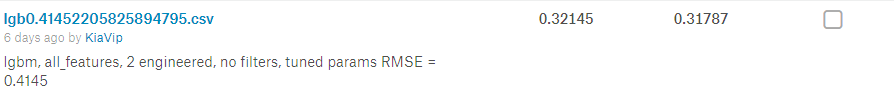

### Part 11. Conclusions

This was my very first experience for competing on Kaggle (although without appear on a leaderboard actualy).

I was able to explore given data, find some dependencies and relations. Also i caught the idea of droping some irrelevant or bad (outlied) train data in favor of important features.

I used regression with gradient boosting LightGBM library, I used it for the second time and gain valuable results. This approach can show feature importance and therefore interpretable! One can see which variables made most significant effect on prediction and may considerate to find other reliable data and features to futher improve model and forecasts.

There are many ways to improve the solution, as it is, obviously, not the best one. I could use ensemble of different models, cleanse data based on outer datasets and realty agencies datasets. I could provide more complex feature engeneering, for example based on macroeconomical feature changes and on rolling time intervals. Also, I could use PCA or another GB model (XGboost) as a most important feature selector.

But there is also time limits and perfomance issues, so my decision may be not the worst for some cases, and when I'll face similar task, I'll bring this code and get the job done!